# TIØ4317 - Empirical and Quantitative Methods in Finance Project 

In [22]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf


In [23]:
ticker_Bitcoin = yf.Ticker("BTC-USD")  
df_Bitcoin = ticker_Bitcoin.history(period="5y")  

ticker_Bitcoin_Cash = yf.Ticker("BCH-USD")  
df_Bitcoin_Cash = ticker_Bitcoin_Cash.history(period="5y")  


In [24]:
# Data cleaning for Bitcoin
print("Datafile head: \n", df_Bitcoin.head())       
print("Checking for null values:")       
print( df_Bitcoin.info())
print("Statistical precentiles: \n", df_Bitcoin.describe())


Datafile head: 
                                   Open         High          Low        Close  \
Date                                                                            
2020-03-22 00:00:00+00:00  6185.558105  6359.697266  5823.713867  5830.254883   
2020-03-23 00:00:00+00:00  5831.374512  6443.934570  5785.004395  6416.314941   
2020-03-24 00:00:00+00:00  6436.642578  6789.022949  6411.066406  6734.803711   
2020-03-25 00:00:00+00:00  6738.716797  6892.511230  6536.926270  6681.062988   
2020-03-26 00:00:00+00:00  6675.170898  6735.463867  6590.962891  6716.440430   

                                Volume  Dividends  Stock Splits  
Date                                                             
2020-03-22 00:00:00+00:00  40099664740        0.0           0.0  
2020-03-23 00:00:00+00:00  46491916000        0.0           0.0  
2020-03-24 00:00:00+00:00  48221910672        0.0           0.0  
2020-03-25 00:00:00+00:00  44590107888        0.0           0.0  
2020-03-26 00:00:00

In [25]:
# Data cleaning for Bitcoin Cash
print("Datafile head: \n", df_Bitcoin_Cash.head())       
print("Checking for null values:")       
print( df_Bitcoin_Cash.info())    
print("Statistical precentiles: \n", df_Bitcoin_Cash.describe())   

Datafile head: 
                                  Open        High         Low       Close  \
Date                                                                        
2020-03-22 00:00:00+00:00  219.599045  229.779892  202.991180  203.672287   
2020-03-23 00:00:00+00:00  203.528076  219.850739  200.744995  219.330475   
2020-03-24 00:00:00+00:00  219.824356  229.325882  218.090347  227.246094   
2020-03-25 00:00:00+00:00  227.405396  228.288177  215.917816  220.440353   
2020-03-26 00:00:00+00:00  220.528885  226.855225  220.528885  226.823120   

                               Volume  Dividends  Stock Splits  
Date                                                            
2020-03-22 00:00:00+00:00  4015953536        0.0           0.0  
2020-03-23 00:00:00+00:00  4187958180        0.0           0.0  
2020-03-24 00:00:00+00:00  3821906574        0.0           0.0  
2020-03-25 00:00:00+00:00  3456700025        0.0           0.0  
2020-03-26 00:00:00+00:00  3364466566        0.0     

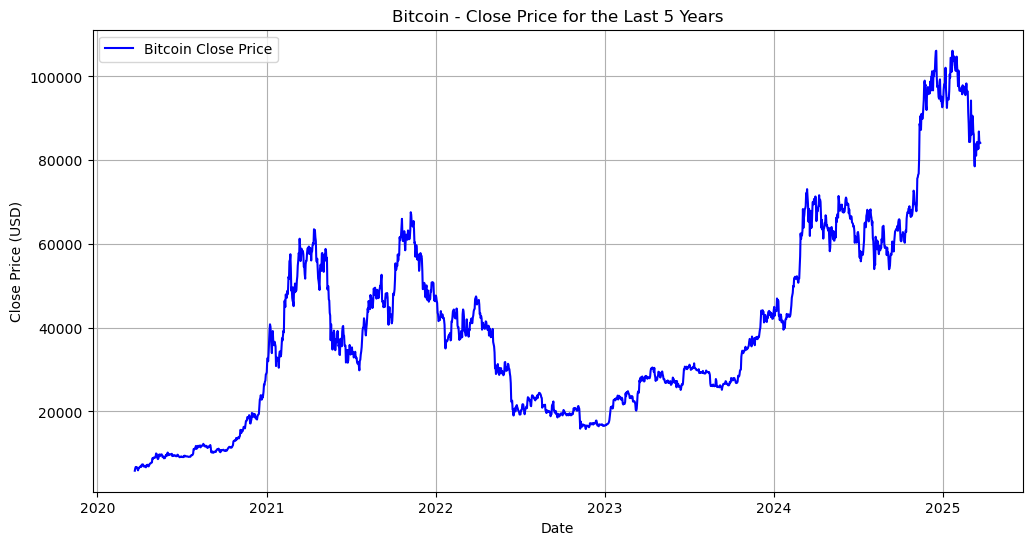

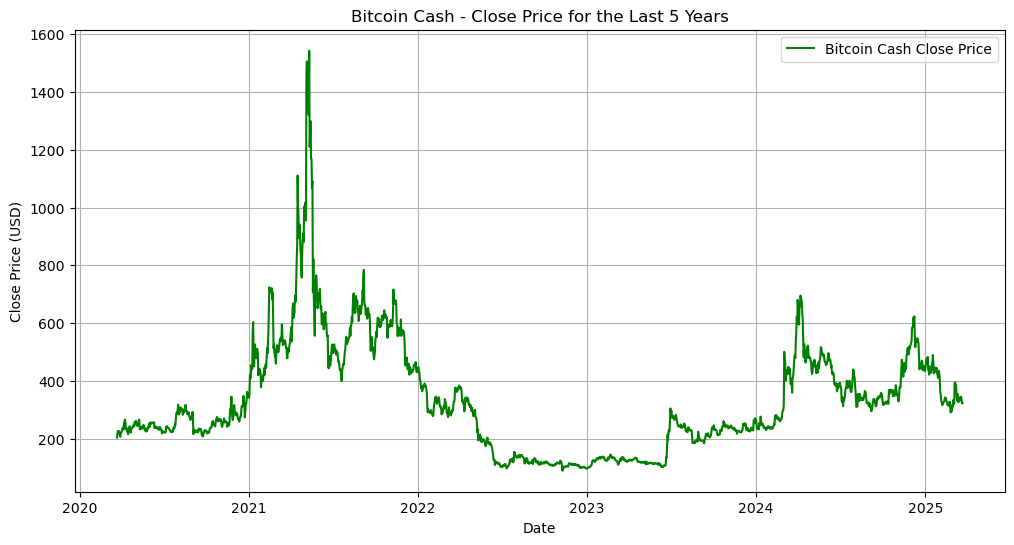

In [26]:
# Plotting closing prices for each day the last 5 years

# Plot for Bitcoin
plt.figure(figsize=(12, 6))
plt.plot(df_Bitcoin.index, df_Bitcoin["Close"], label="Bitcoin Close Price", color="blue")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.title("Bitcoin - Close Price for the Last 5 Years")
plt.legend()
plt.grid()
plt.show()

# Plot for Bitcoin Cash
plt.figure(figsize=(12, 6))
plt.plot(df_Bitcoin_Cash.index, df_Bitcoin_Cash["Close"], label="Bitcoin Cash Close Price", color="green")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.title("Bitcoin Cash - Close Price for the Last 5 Years")
plt.legend()
plt.grid()
plt.show()
